# Imports

In [ ]:
%%capture

!pip install category_encoders
!pip install ipywidgets

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image

import category_encoders as ce
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Task 1 (40 points)

* EDA (10 points)
* Explain general setup of feature engineering (10 points)
* Use of scientific literature supporting the setup (5 points)
* Rationale for choice of final attributes (15 points)

In [162]:
df = pd.read_csv('data/mood.csv')
df['time'] = pd.to_datetime(df['time'])
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26 13:00:00,mood,6.0
1,2,AS14.01,2014-02-26 15:00:00,mood,6.0
2,3,AS14.01,2014-02-26 18:00:00,mood,6.0
3,4,AS14.01,2014-02-26 21:00:00,mood,7.0
4,5,AS14.01,2014-02-27 09:00:00,mood,6.0


## EDA and preprocessing

In [3]:
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

We see that the column value contains potential outliers

### What are the dates of the experiment

In [45]:
df.groupby('id')['time'].agg(['min', 'max']).sort_values(['min'])

,min,max
id,,
AS14.02,2014-02-17 07:00:52.197,2014-04-25 21:00:00.000
AS14.06,2014-02-17 07:12:13.631,2014-05-08 09:00:00.000
AS14.14,2014-02-17 07:49:19.635,2014-05-05 15:00:00.000
AS14.17,2014-02-17 08:57:16.313,2014-05-05 15:00:00.000
AS14.19,2014-02-17 08:58:58.471,2014-05-05 18:00:00.000
AS14.28,2014-02-17 09:48:49.536,2014-05-08 13:37:16.006
AS14.20,2014-02-17 09:52:02.075,2014-05-05 13:00:00.000
AS14.26,2014-02-17 09:58:59.766,2014-05-30 21:00:00.000
AS14.29,2014-02-17 10:42:05.661,2014-05-15 12:00:00.000


Most of the participants started at the same time. The experiment lasted for a bit more than 2 months. A couple of participants started 1+ month later. Our guess is that the students are from NL and all live in the same timezone

### What are the values for different kinds of interaction with the device

In [46]:
df.groupby(['variable'])['value'].agg(['min', 'max'])

,min,max
variable,,
activity,0.000,1.000
appCat.builtin,-82798.871,33960.246
appCat.communication,0.006,9830.777
appCat.entertainment,-0.011,32148.677
appCat.finance,0.131,355.513
appCat.game,1.003,5491.793
appCat.office,0.003,32708.818
appCat.other,0.014,3892.038
appCat.social,0.094,30000.906


1. call, sms appear only when there is a fact of this action, so there are no zeros.  
2. the duration of the call may be approximately calculated from the next event (rarely possible).  
3. activity is the value collected hourly. mean sth like the percentage ratio of the hour when the user was active.  
4. mood and circumplex are discrete
5. all the others mean the number of seconds spent on each of the activities

TODO:
1. All activities sum to the screen time
2. Add blink screen usages as a feature

### Outliers

In [47]:
df['variable'].unique()

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

#### appCat.builtin

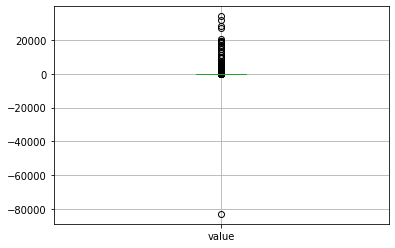

In [48]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [49]:
df[(df['variable'] == 'appCat.builtin')&(df['value'] < -80000)]

,Unnamed: 0,id,time,variable,value
159972,622771,AS14.07,2014-04-30 14:18:06.200,appCat.builtin,-82798.871


In [50]:
df.shape

(376912, 5)

In [51]:
df.drop(159972, axis=0, inplace=True)
df.shape

(376911, 5)

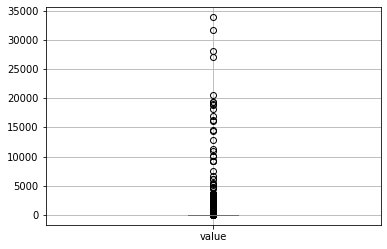

In [52]:
df[df['variable'] == 'appCat.builtin'].boxplot(column=['value']);

In [53]:
# df[df['value'] == df[df['variable'] == 'appCat.builtin'].agg({'value': ['min', 'max']})]

#### appCat.entertainment

In [54]:
df[(df['variable'] == 'appCat.entertainment') & (df['value'] < 0)]

,Unnamed: 0,id,time,variable,value
309805,484694,AS14.02,2014-03-26 21:18:45.144,appCat.entertainment,-0.011


In [55]:
df.drop(309805, axis=0, inplace=True)
df.shape

(376910, 5)

#### appCat.office

In [56]:
df[(df['variable'] == 'appCat.office') & (df['value'] > 5000)]

,Unnamed: 0,id,time,variable,value
340707,1356866,AS14.29,2014-04-19 23:15:02.463,appCat.office,32708.818
342284,1360733,AS14.29,2014-05-03 12:34:14.911,appCat.office,5691.982


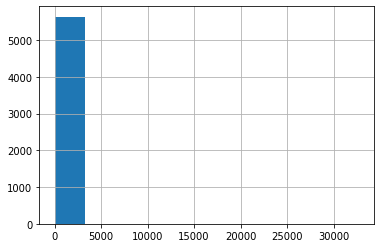

In [57]:
df[df['variable'] == 'appCat.office']['value'].hist();

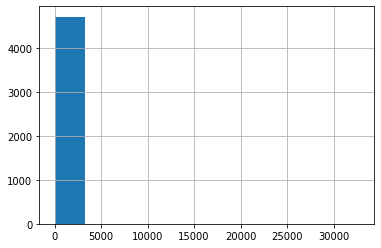

In [58]:
df[(df['id'] == 'AS14.29') & (df['variable'] == 'appCat.office')]['value'].hist();

33k seconds is about 9 hours. In general (and for this subject as well), we see that the time spent in the office apps is significantly smaller so we treat this case as a forgotten opened app

In [59]:
df.drop(340707, axis=0, inplace=True)
df.shape

(376909, 5)

### Activity. Can it be a proxy for sleep? 

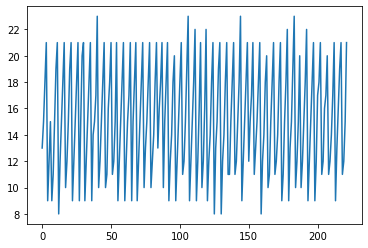

In [60]:
df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.plot();

In [61]:
sorted(df[(df['id'] == 'AS14.01') & (df['variable'] == 'mood')].sort_values(['time'])['time'].dt.hour.unique())

[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

<Figure size 1224x864 with 0 Axes>

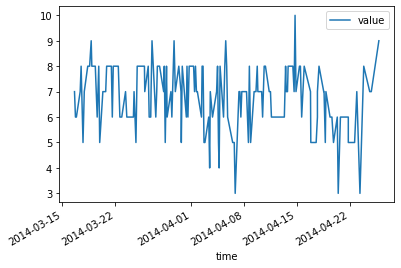

In [62]:
plt.figure(figsize=(17, 12))
df[(df['id'] == 'AS14.02') & (df['variable'] == 'mood')].sort_values(['time']).plot('time', 'value');

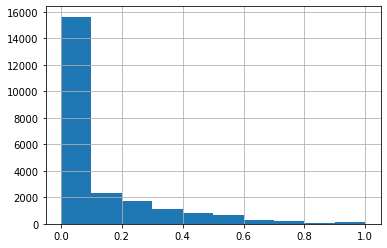

In [63]:
df[df['variable'] == 'activity']['value'].hist();

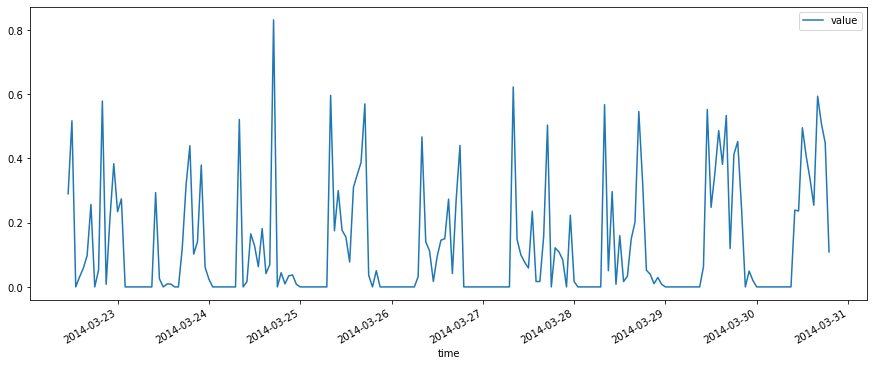

In [64]:
df[(df['id'] == 'AS14.03') & (df['variable'] == 'activity')].sort_values(['time']).head(200).plot(x='time', y='value', figsize=(15,6));

TODO: 
1. add a binary (sth else) feature for sleep\not. sleep should be mutually exclusive with mood records
    1. continous period of 5+ hours
    2. correct it with surrounding events 
2. for each of the users use 75% percentile as sports

### Was the circumplex collected at the same time as the mood?

In [65]:
Image(url= "images/circumplex_model.png", width=400, height=400)

In [66]:
targets_num_df = df[df['variable'].isin(['mood', 'circumplex.valence', 'circumplex.arousal'])].\
    groupby(['id', 'time'])['variable'].unique()
targets_num_df.head()

id       time               
AS14.01  2014-02-26 13:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 15:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 18:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-26 21:00:00    [mood, circumplex.arousal, circumplex.valence]
         2014-02-27 09:00:00    [mood, circumplex.arousal, circumplex.valence]
Name: variable, dtype: object

In [67]:
targets_num_df[targets_num_df.apply(lambda x: len(x)) != 3]

Series([], Name: variable, dtype: object)

We don't see the cases when mood, circumplex.arousal, circumplex.valence were collected not at the same time. As they are all logically connected, we may conclude that not only the mood was collected as a target during the experiment, but the circumplex as well. Therefore, we have to treat this carefully as including of circumplex while predicting mood for the same time will have a clear leak

### Do we have the same variable indicated at the same time for the same user?

In [68]:
df.duplicated(['id', 'time', 'variable']).value_counts()

False    376866
True         43
dtype: int64

In [69]:
df[df.duplicated(['id', 'time', 'variable'], keep=False)]

,Unnamed: 0,id,time,variable,value
135,136,AS14.01,2014-04-17 11:00:00,mood,7.0
136,137,AS14.01,2014-04-17 11:00:00,mood,6.0
358,359,AS14.02,2014-04-17 18:00:00,mood,6.0
359,360,AS14.02,2014-04-17 18:00:00,mood,7.0
371,372,AS14.02,2014-04-21 20:00:00,mood,5.0
372,373,AS14.02,2014-04-21 20:00:00,mood,6.0
937,938,AS14.06,2014-04-13 17:00:00,mood,7.0
938,939,AS14.06,2014-04-13 17:00:00,mood,5.0
1748,1749,AS14.12,2014-03-30 11:00:00,mood,6.0
1749,1750,AS14.12,2014-03-30 11:00:00,mood,7.0


In [70]:
df[df['variable'] == 'mood']['value'].unique()

array([ 6.,  7.,  5.,  8.,  9.,  4.,  3., 10.,  2.,  1.])

we see the duplicates. probably, they mean fractions (6.5, 0.5 etc)  
TODO Ned: find evidence

In [71]:
df = df.groupby(['id', 'time', 'variable']).mean().reset_index()
df.shape

(376866, 5)

In [163]:
df[(df['id'] == 'AS14.01') & (df['time'] == '2014-04-17 11:00:00')]

,Unnamed: 0,id,time,variable,value
135,136,AS14.01,2014-04-17 11:00:00,mood,7.00000
136,137,AS14.01,2014-04-17 11:00:00,mood,6.00000
5776,5777,AS14.01,2014-04-17 11:00:00,circumplex.arousal,-1.00000
5777,5778,AS14.01,2014-04-17 11:00:00,circumplex.arousal,-2.00000
11419,11420,AS14.01,2014-04-17 11:00:00,circumplex.valence,1.00000
11420,11421,AS14.01,2014-04-17 11:00:00,circumplex.valence,0.00000
17558,17559,AS14.01,2014-04-17 11:00:00,activity,0.05042


the unnamed (index) is weird

## Feature engineering non-dependent on train-test split

time may be encoded with a trigonometrical function to link 23 and 0

check the timing(hour) distribution across the days

don't forget to try find their local times (the first measurement is done in the morning)

## Pivoting data from the previous days as features

## Aggregating and Pivoting

In [164]:
df['time'] = df['time'].dt.floor('D')
df.head()

,Unnamed: 0,id,time,variable,value
0,1,AS14.01,2014-02-26,mood,6.0
1,2,AS14.01,2014-02-26,mood,6.0
2,3,AS14.01,2014-02-26,mood,6.0
3,4,AS14.01,2014-02-26,mood,7.0
4,5,AS14.01,2014-02-27,mood,6.0


In [165]:
#aggregate different categories of values
df2 = df[df['variable'].isin(['mood', 'circumplex.arousal', 'circumplex.valence'])].groupby(['id', 'time', 'variable']).mean() #calculate mean for mood and circumplex
df3 = df[~df['variable'].isin(['mood', 'circumplex.arousal', 'circumplex.valence'])].groupby(['id', 'time', 'variable']).sum() #sum for everything else

In [166]:
df_agg = pd.concat([df2,df3])

In [167]:
pivoted_df = pd.pivot_table(df_agg, values = 'value', index=['id','time'], columns = 'variable').reset_index()

### Dealing with NaNs
we don't do this before as added values may influence the aggregation  
most of the features are timings while the others are the presence of calls or sms. Therefore, we can replace NaNs with zeros meaning no activity

In [168]:
pivoted_df.drop(pivoted_df[pivoted_df['mood'].isna()].index, inplace=True)
pivoted_df = pivot.fillna(0)
pivoted_df.sort_values(['id','time'], inplace=True)

In [169]:
enc = ce.OrdinalEncoder(cols=['time'])
pivoted_df = enc.fit_transform(pivoted_df)

In [190]:
pivoted_df['mood_prev1'] = pivoted_df['mood'].shift(1)
pivoted_df['id_prev'] = pivoted_df['id'].shift(1)

In [192]:
pivoted_df = pivoted_df[pivoted_df['id_prev'] == pivoted_df['id']]
pivoted_df.drop('id_prev', axis=1, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [195]:
pivoted_df.head(10)

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,mood_prev1
26,AS14.01,3,3.083152,3139.218,6280.890,1007.456,49.544,0.000,172.206,239.751,4508.500,915.445,0.000,598.754,0.000,6.0,0.2,0.20,6.20,17978.907000,0.0,6.333333
27,AS14.01,4,3.790084,731.429,4962.918,93.324,21.076,0.000,0.000,98.143,439.632,37.305,0.000,117.621,0.000,3.0,0.6,0.50,6.40,6142.161000,1.0,6.200000
28,AS14.01,5,2.141117,1286.246,5237.319,94.346,43.403,0.000,0.000,72.823,900.839,0.000,0.000,30.086,30.386,0.0,0.2,0.80,6.80,6773.832001,0.0,6.400000
29,AS14.01,6,1.895065,866.956,9270.629,976.971,34.106,0.000,3.010,66.558,3223.626,419.805,0.000,178.732,0.000,10.0,0.8,0.00,6.00,15047.351001,0.0,6.800000
30,AS14.01,7,2.360979,1032.768,10276.751,68.206,43.054,0.000,0.000,178.819,1919.471,0.000,235.223,222.893,0.000,0.0,0.5,0.50,6.75,21475.354999,1.0,6.000000
31,AS14.01,8,2.431400,1167.497,8988.753,910.479,52.331,0.000,0.000,97.498,4592.059,0.000,0.000,33.365,0.000,0.0,-0.2,0.60,6.60,16423.801000,0.0,6.750000
32,AS14.01,9,3.509234,1229.327,6936.512,639.339,42.219,0.000,182.451,58.532,935.381,47.314,0.000,179.029,0.000,2.0,0.2,0.80,7.00,17442.149999,1.0,6.600000
33,AS14.01,10,2.296753,10062.595,866.833,1005.403,89.166,233.036,0.000,225.951,512.741,1133.009,0.000,301.717,0.000,5.0,-0.6,0.60,6.40,4923.489000,0.0,7.000000
34,AS14.01,11,1.636867,1952.630,2720.692,1627.429,0.000,0.000,0.000,169.594,472.888,52.435,0.000,600.637,0.000,4.0,0.2,1.00,8.00,8322.622000,1.0,6.400000
35,AS14.01,12,0.687302,414.365,1298.505,1535.677,0.000,0.000,0.000,74.003,167.685,0.000,66.477,38.296,0.000,0.0,-0.5,0.75,7.50,4523.214001,0.0,8.000000


## Train-test split

In [127]:
from sklearn.model_selection import train_test_split#, StratifiedKFold

as we are going to predict in the feature, we will be able to train ML models only in the past

In [128]:
pivoted_df = pivoted_df.sort_values(['time'], ascending=True)
pivoted_df.head()

variable,id,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
7,AS14.01,1,0.000000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,1.0,-0.25,0.750000,6.250000,0.000000,2.0
8,AS14.01,2,0.000000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.00,0.333333,6.333333,0.000000,0.0
1662,AS14.30,3,3.183892,945.146,3108.808,4282.086,0.0,0.0,0.000,468.773,1685.434,0.0,61.8,87.215,0.0,3.0,-0.40,1.200000,7.800000,9825.663999,2.0
168,AS14.03,3,0.000000,168.055,1724.739,946.017,0.0,0.0,10.046,543.588,0.000,0.0,0.0,0.000,0.0,5.0,1.00,2.000000,9.000000,1664.954001,2.0
790,AS14.15,3,0.623016,960.108,195.220,0.000,0.0,0.0,3.010,14.117,0.000,0.0,0.0,0.000,0.0,5.0,0.20,0.800000,7.000000,820.120000,0.0


TODO: consider one model per each id (with a separate split for each)

In [129]:
#pivoted_df['mood'].value_counts()

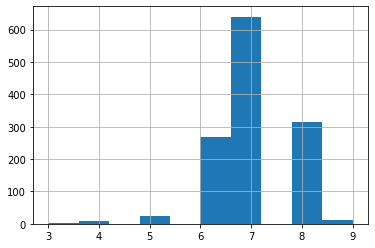

In [130]:
pivoted_df['mood'] = round(pivoted_df['mood'])
pivoted_df['mood'].hist();

In [131]:
y = pivoted_df['mood']

X_train, X_test, y_train, y_test = train_test_split(pivoted_df.drop(['mood'], axis=1), 
                                                    y, train_size=0.7, shuffle=False)

## Feature engineering

### Categoricals

ID may be encoded in advance as we do not expect new users during test period

In [132]:
enc = ce.OneHotEncoder(cols=['id'], 
                       use_cat_names=True)

X_train = enc.fit_transform(X_train)
print('X_train.shape', X_train.shape)
X_train.head(3)

X_train.shape (887, 46)


,id_AS14.01,id_AS14.30,id_AS14.03,id_AS14.15,id_AS14.07,id_AS14.16,id_AS14.08,id_AS14.02,id_AS14.09,id_AS14.20,id_AS14.19,id_AS14.13,id_AS14.05,id_AS14.17,id_AS14.14,id_AS14.23,id_AS14.26,id_AS14.06,id_AS14.12,id_AS14.28,id_AS14.32,id_AS14.31,id_AS14.29,id_AS14.27,id_AS14.25,id_AS14.24,id_AS14.33,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,screen,sms
7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,1.0,-0.25,0.750000,0.000000,2.0
8,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0.000000,0.000,0.000,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.00,0.333333,0.000000,0.0
1662,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3.183892,945.146,3108.808,4282.086,0.0,0.0,0.0,468.773,1685.434,0.0,61.8,87.215,0.0,3.0,-0.40,1.200000,9825.663999,2.0


In [133]:
X_test = enc.transform(X_test)
X_test.tail(2)

,id_AS14.01,id_AS14.30,id_AS14.03,id_AS14.15,id_AS14.07,id_AS14.16,id_AS14.08,id_AS14.02,id_AS14.09,id_AS14.20,id_AS14.19,id_AS14.13,id_AS14.05,id_AS14.17,id_AS14.14,id_AS14.23,id_AS14.26,id_AS14.06,id_AS14.12,id_AS14.28,id_AS14.32,id_AS14.31,id_AS14.29,id_AS14.27,id_AS14.25,id_AS14.24,id_AS14.33,time,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,screen,sms
1249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,97,1.965438,5027.498,735.965,0.0,0.0,0.0,0.0,6.214,106.85,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,5530.377999,2.0
1250,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,98,0.318041,351.389,375.515,0.0,0.0,0.0,0.0,18.069,190.76,0.0,0.0,0.0,0.0,0.0,-1.5,1.0,1131.197999,0.0


### Normalising

# Task 2

## Evaluation

In [134]:
def eval_clf(y_test, test_pred):
    clf_report = classification_report(y_test,
                                       test_pred,)

    print(clf_report)

    conf_matrix = confusion_matrix(y_test,
                                   test_pred)
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_test))
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.grid(False)
    disp.plot(ax=ax)

## Predict mood same as previous day baseline (Benchmark Model (4 points))

              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         2
         4.0       0.25      0.25      0.25         8
         5.0       0.09      0.09      0.09        22
         6.0       0.46      0.45      0.45       258
         7.0       0.60      0.61      0.60       611
         8.0       0.47      0.47      0.47       302
         9.0       0.00      0.00      0.00        11

    accuracy                           0.52      1214
   macro avg       0.27      0.27      0.27      1214
weighted avg       0.52      0.52      0.52      1214



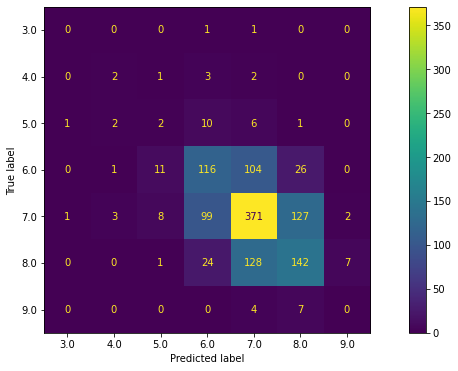

In [201]:
eval_clf(pivoted_df['mood'].round(0), pivoted_df['mood_prev1'].round(0))

## Average baseline (Benchmark Model (4 points))

In [135]:
avg_mood = np.mean(y_train)

In [136]:
avg_mood

7.012401352874859

In [137]:
test_pred = np.full(y_test.shape, round(avg_mood))

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00        12
         6.0       0.00      0.00      0.00        79
         7.0       0.55      1.00      0.71       208
         8.0       0.00      0.00      0.00        80
         9.0       0.00      0.00      0.00         2

    accuracy                           0.55       381
   macro avg       0.11      0.20      0.14       381
weighted avg       0.30      0.55      0.39       381



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

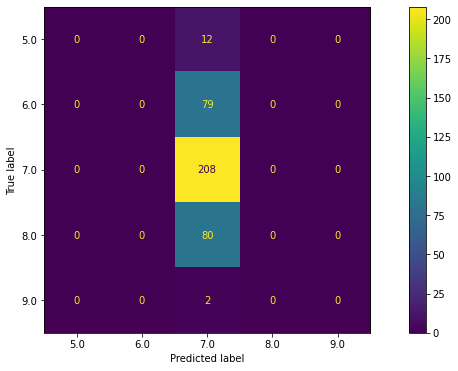

In [138]:
eval_clf(y_test, test_pred)

## Feature Engineered model (8 points)

### DecisionTreeClassifier

In [139]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth=4)
clf = clf.fit(X_train, y_train)

              precision    recall  f1-score   support

         3.0       0.67      1.00      0.80         2
         4.0       1.00      0.75      0.86         8
         5.0       0.00      0.00      0.00        12
         6.0       0.75      0.38      0.51       188
         7.0       0.61      0.93      0.74       432
         8.0       0.80      0.42      0.55       235
         9.0       1.00      0.30      0.46        10

    accuracy                           0.66       887
   macro avg       0.69      0.54      0.56       887
weighted avg       0.69      0.66      0.63       887



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

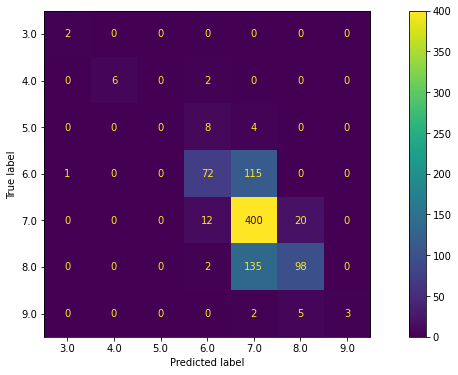

In [140]:
train_pred = clf.predict(X_train)
eval_clf(y_train, train_pred)

              precision    recall  f1-score   support

         5.0       0.00      0.00      0.00        12
         6.0       0.56      0.32      0.40        79
         7.0       0.63      0.88      0.73       208
         8.0       0.62      0.33      0.43        80
         9.0       0.00      0.00      0.00         2

    accuracy                           0.62       381
   macro avg       0.36      0.31      0.31       381
weighted avg       0.59      0.62      0.57       381



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

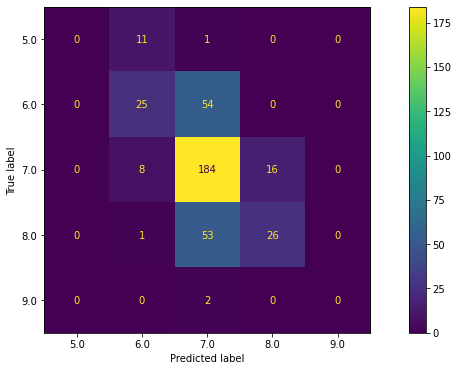

In [141]:
test_pred = clf.predict(X_test)
eval_clf(y_test, test_pred)

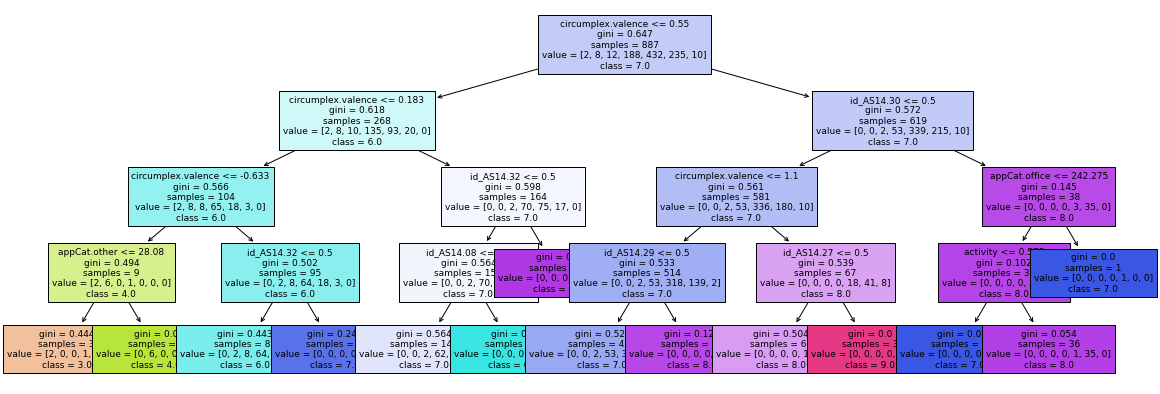

In [142]:
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt

fig, axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(20, 7))

from sklearn import tree
tree.plot_tree(clf, 
               feature_names=X_test.columns, 
               class_names=[str(c) for c in clf.classes_],
            filled=True,
            max_depth=4,
            fontsize=9,
               );

In [143]:
y_test[X_test[X_test['id_AS14.30'] == 1].index]

1700    8.0
1701    8.0
1702    8.0
1703    8.0
1704    8.0
1705    8.0
1706    8.0
1661    7.0
1707    8.0
Name: mood, dtype: float64

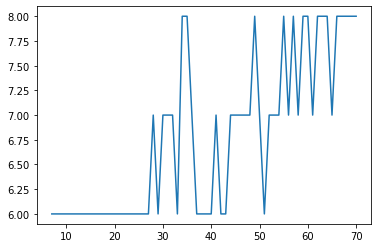

In [144]:
pivoted_df[pivoted_df['id'] == 'AS14.01']['mood'].plot();

### RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(max_depth=8)
clf = clf.fit(X_train, y_train)

train_pred = clf.predict(X_train)
eval_clf(y_train, train_pred)

In [ ]:
test_pred = clf.predict(X_test)
eval_clf(y_test, test_pred)

In [ ]:
for el in sorted(zip(X_train.columns, clf.feature_importances_), key=lambda x: x[1], 
                 reverse=True):
    print(el)

## Temporal Model 8

TODO NED: add plots

### AR model

### ARIMA

In [ ]:
y = train_test_dict['AS14.01']['train']

# Maps each participant to a fitted model
model_dict = {}
for participant in participants:
    train = train_test_dict[participant]['train']
    
    model = pm.auto_arima(train, start_p=1, start_q=1,
                          test='adf',       # use adftest to find optimal 'd'
                          max_p=5, max_q=5, # maximum p and q
                          m=1,              # frequency of series
                          d=None,           # let model determine 'd'
                          seasonal=False,   # No Seasonality (Might have to check for this shit?)
                          start_P=0, 
                          D=0, 
                          trace=False,
                          error_action='ignore',  
                          suppress_warnings=True, 
                          stepwise=True)
    model_dict[participant] = model

for participant in sorted(model_dict.keys()):
    model = model_dict[participant]
    print(f"{participant}\t\tAIC: {np.round(model.aic(), 2):.2f}\tBIC: {np.round(model.bic(), 2):.2f}\tParameters: {model.order}")

### Prophet

## Evaluation (validation / test) 10

## Illustrate performance with graphs 10